In [2]:
## Langchain with Tool for Websearch Tavily

In [3]:
!pip install -U langchain langchain-chroma pypdf sentence-transformers langgraph langchain_openai langchain_community -q

## Setup API keys

In [5]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [6]:
_set_env("TAVILY_API_KEY")

TAVILY_API_KEY: ··········


In [7]:
_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


## Creating LLM

In [8]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model_name="gpt-4o")

## WebSearch Tool

In [9]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(max_results=2)

## RAG Tool

In [13]:
from langchain_community.document_loaders import PyPDFLoader, Docx2txtLoader, TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing import List
from langchain_core.documents import Document
import os

def load_documents(folder_path: str) -> List[Document]:
    documents = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.endswith('.pdf'):
            loader = PyPDFLoader(file_path)
        elif filename.endswith('.docx'):
            loader = Docx2txtLoader(file_path)
        elif filename.endswith('.txt'):
            loader = TextLoader(file_path)
        else:
            print(f"Unsupported file type: {filename}")
            continue
        documents.extend(loader.load())
    return documents

folder_path = "/content/docs"
documents = load_documents(folder_path)
print(f"Loaded {len(documents)} documents from the folder.")


Loaded 1 documents from the folder.


In [14]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len
)

splits = text_splitter.split_documents(documents)
print(f"Split the documents into {len(splits)} chunks.")

Split the documents into 6 chunks.


In [15]:
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings

embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

from langchain_chroma import Chroma

collection_name = "my_collection"
vectorstore = Chroma.from_documents(
    collection_name=collection_name,
    documents=splits,
    embedding=embedding_function,
    persist_directory="./chroma_db"
)
print("Vector store created and persisted to './chroma_db'")

<ipython-input-15-3b6e8575ed3e>:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or dataset

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Vector store created and persisted to './chroma_db'


In [16]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 2})
retriever_results = retriever.invoke("Who was the founder of Linkedin?")
print(retriever_results)

[Document(id='5919fad6-e4fe-45a3-b0ff-6a56d4d26335', metadata={'source': '/content/docs/LinkedInOverview.txt'}, page_content='LinkedIn: A Comprehensive Overview\n\nIntroduction\n\nLinkedIn is the world’s largest professional networking platform, connecting millions of professionals across various industries. Founded in 2002 by Reid Hoffman and officially launched in 2003, LinkedIn has grown to become a crucial tool for job seekers, recruiters, businesses, and industry experts. The platform facilitates networking, knowledge sharing, job searching, and business development opportunities. As of 2024, LinkedIn has over 900 million members spanning across 200 countries.\n\nFeatures and Functionalities\n\nLinkedIn offers a wide range of features designed to enhance professional growth and engagement:\n\n1. Profiles\n\nEach LinkedIn user has a personal profile that serves as a digital resume. Users can include details such as:\n\nProfile picture and banner image\n\nHeadline summarizing their 

In [17]:
from langchain.tools import tool
from pydantic import BaseModel

class RagToolSchema(BaseModel):
    question: str

@tool(args_schema=RagToolSchema)
def retriever_tool(question):
  """Tool to Retrieve Semantically Similar documents to answer User Questions related to FutureSmart AI"""
  print("INSIDE RETRIEVER NODE")
  retriever = vectorstore.as_retriever(search_kwargs={"k": 2})
  retriever_result = retriever.invoke(question)
  return "\n\n".join(doc.page_content for doc in retriever_results)

## NL2SQL Tool

### Setting up DB for NL2SQL

In [18]:
!wget https://github.com/lerocha/chinook-database/raw/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite

--2025-02-25 04:32:54--  https://github.com/lerocha/chinook-database/raw/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite [following]
--2025-02-25 04:32:54--  https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1067008 (1.0M) [application/octet-stream]
Saving to: ‘Chinook_Sqlite.sqlite’

Chinook_Sqlite.sqli 100%[===================>]   1.02M  --.-KB/

In [19]:
!mv Chinook_Sqlite.sqlite Chinook.db

In [20]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")

### Function to Get the Correct SQL Query from the LLM

In [21]:
import re

def clean_sql_query(text: str) -> str:
    """
    Clean SQL query by removing code block syntax, various SQL tags, backticks,
    prefixes, and unnecessary whitespace while preserving the core SQL query.

    Args:
        text (str): Raw SQL query text that may contain code blocks, tags, and backticks

    Returns:
        str: Cleaned SQL query
    """
    # Step 1: Remove code block syntax and any SQL-related tags
    # This handles variations like ```sql, ```SQL, ```SQLQuery, etc.
    block_pattern = r"```(?:sql|SQL|SQLQuery|mysql|postgresql)?\s*(.*?)\s*```"
    text = re.sub(block_pattern, r"\1", text, flags=re.DOTALL)

    # Step 2: Handle "SQLQuery:" prefix and similar variations
    # This will match patterns like "SQLQuery:", "SQL Query:", "MySQL:", etc.
    prefix_pattern = r"^(?:SQL\s*Query|SQLQuery|MySQL|PostgreSQL|SQL)\s*:\s*"
    text = re.sub(prefix_pattern, "", text, flags=re.IGNORECASE)

    # Step 3: Extract the first SQL statement if there's random text after it
    # Look for a complete SQL statement ending with semicolon
    sql_statement_pattern = r"(SELECT.*?;)"
    sql_match = re.search(sql_statement_pattern, text, flags=re.IGNORECASE | re.DOTALL)
    if sql_match:
        text = sql_match.group(1)

    # Step 4: Remove backticks around identifiers
    text = re.sub(r'`([^`]*)`', r'\1', text)

    # Step 5: Normalize whitespace
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)

    # Step 6: Preserve newlines for main SQL keywords to maintain readability
    keywords = ['SELECT', 'FROM', 'WHERE', 'GROUP BY', 'HAVING', 'ORDER BY',
               'LIMIT', 'JOIN', 'LEFT JOIN', 'RIGHT JOIN', 'INNER JOIN',
               'OUTER JOIN', 'UNION', 'VALUES', 'INSERT', 'UPDATE', 'DELETE']

    # Case-insensitive replacement for keywords
    pattern = '|'.join(r'\b{}\b'.format(k) for k in keywords)
    text = re.sub(f'({pattern})', r'\n\1', text, flags=re.IGNORECASE)

    # Step 7: Final cleanup
    # Remove leading/trailing whitespace and extra newlines
    text = text.strip()
    text = re.sub(r'\n\s*\n', '\n', text)

    return text

### Creating NL2SQL Tool

In [22]:
from langchain.chains import create_sql_query_chain
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from operator import itemgetter
import re
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

class SQLToolSchema(BaseModel):
    question: str

@tool(args_schema=SQLToolSchema)
def nl2sql_tool(question):
  """Tool to Generate and Execute SQL Query to answer User Questions related to chinook DB"""
  print("INSIDE NL2SQL TOOL")
  execute_query = QuerySQLDataBaseTool(db=db)
  write_query = create_sql_query_chain(llm, db)

  chain = (
      RunnablePassthrough.assign(query=write_query | RunnableLambda(clean_sql_query)).assign(
          result=itemgetter("query") | execute_query
      )
  )

  response = chain.invoke({"question": question})
  return response['result']

question = "How many employees are there?"
result = nl2sql_tool.invoke({"question": question})
print(f"Question: {question}")
print(f"Answer: {result}")

INSIDE NL2SQL TOOL


<ipython-input-22-a953639c3dfa>:16: LangChainDeprecationWarning: The class `QuerySQLDataBaseTool` was deprecated in LangChain 0.3.12 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-community package and should be used instead. To use it run `pip install -U :class:`~langchain-community` and import as `from :class:`~langchain_community.tools import QuerySQLDatabaseTool``.
  execute_query = QuerySQLDataBaseTool(db=db)


Question: How many employees are there?
Answer: [(8,)]


## Combining all Tools

In [23]:
tools = [web_search_tool, retriever_tool, nl2sql_tool]
llm_with_tools = llm.bind_tools(tools)

In [24]:
from typing import Annotated

from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

# Setting up the graph state
class State(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[web_search_tool, retriever_tool, nl2sql_tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

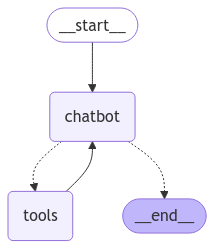

In [25]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # You can put your exception handling code here
    pass

In [26]:
config = {"configurable": {"thread_id": "1"}}

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    # Process user input through the LangGraph
    for event in graph.stream({"messages": [("user", user_input)]}, config):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

User: who is founder of Linkedin
Assistant: LinkedIn was founded by Reid Hoffman and a team of founding members including Allen Blue, Konstantin Guericke, Eric Ly, and Jean-Luc Vaillant. Reid Hoffman played a significant role in the establishment and development of LinkedIn.
User: exit
Goodbye!
